In [ ]:
!pip install torch torchvision lightly scikit-learn

In [ ]:
# prompt: get data for imagenet and cifar in data folder to be used

!git clone https://github.com/lightly-ai/lightly.git
%cd lightly/examples/image_classification
!mkdir data
!wget https://s3.eu-central-1.amazonaws.com/avg-public-dataset/tiny-imagenet-200/train.zip -P data/
!unzip data/train.zip -d data/
!wget https://s3.eu-central-1.amazonaws.com/avg-public-dataset/tiny-imagenet-200/val.zip -P data/
!unzip data/val.zip -d data/
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -P data/
!tar -xf data/cifar-10-python.tar.gz -C data/


fatal: destination path 'lightly' already exists and is not an empty directory.
[Errno 2] No such file or directory: 'lightly/examples/image_classification'
/content
mkdir: cannot create directory ‘data’: File exists
--2024-06-30 04:00:10--  https://s3.eu-central-1.amazonaws.com/avg-public-dataset/tiny-imagenet-200/train.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 3.5.135.33, 3.5.134.213, 52.219.72.159, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|3.5.135.33|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-06-30 04:00:11 ERROR 404: Not Found.

unzip:  cannot find or open data/train.zip, data/train.zip.zip or data/train.zip.ZIP.
--2024-06-30 04:00:11--  https://s3.eu-central-1.amazonaws.com/avg-public-dataset/tiny-imagenet-200/val.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 3.5.135.33, 3.5.134.213, 52.219.72.159, ...
Connecting to s3.eu-central-1.amazonaw

In [ ]:
# prompt: define unpickle
#       8 path_to_cifar = 'data/cifar-10-batches-py'
# ----> 9 cifar_data = unpickle(os.path.join(path_to_cifar, 'data_batch_1'))
#      10 X_train = cifar_data['data']
#      11 y_train = cifar_data['labels']
# NameError: name 'unpickle' is not

import pickle

def unpickle(file):
  with open(file, 'rb') as fo:
    dict = pickle.load(fo, encoding='bytes')
  return dict

# path_to_cifar = 'data/cifar-10-batches-py'
# cifar_data = unpickle(os.path.join(path_to_cifar, 'data_batch_1'))
# X_train = cifar_data['data']
# y_train = cifar_data['labels']


In [ ]:
!mkdir -p data/cifar-10/train
!mkdir -p data/cifar-10/test

In [ ]:
# prompt: modift cifar data downloaded in such a way that they are png images and can be read by following code

import os
import numpy as np
from PIL import Image

# Load the CIFAR-10 dataset
path_to_cifar = 'data/cifar-10-batches-py'
cifar_data = unpickle(os.path.join(path_to_cifar, 'data_batch_1'))
print(cifar_data.keys())
X_train = cifar_data[b'data']
y_train = cifar_data[b'labels']

# Convert the data to PNG images
for i in range(len(X_train)):
    img = X_train[i].reshape((3, 32, 32)).transpose(1, 2, 0)
    img = Image.fromarray(img)
    img.save(f'data/cifar-10/train/{y_train[i]}_{i}.png')

# Repeat for validation and test sets
cifar_data = unpickle(os.path.join(path_to_cifar, 'test_batch'))
X_test = cifar_data[b'data']
y_test = cifar_data[b'labels']

for i in range(len(X_test)):
    img = X_test[i].reshape((3, 32, 32)).transpose(1, 2, 0)
    img = Image.fromarray(img)
    img.save(f'data/cifar-10/test/{y_test[i]}_{i}.png')


dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [ ]:
import torch
import torchvision
from lightly import loss
from lightly import transforms
from lightly.data import LightlyDataset
from lightly.models.modules import heads

# Define SimCLR model
class SimCLR(torch.nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = heads.SimCLRProjectionHead(
            input_dim=512,  # Adjust based on backbone output
            hidden_dim=512,
            output_dim=128,
        )

    def forward(self, x):
        features = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(features)
        return z

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model and move to GPU if available
backbone = torchvision.models.resnet18(pretrained=False)
backbone.fc = torch.nn.Identity()
model = SimCLR(backbone).to(device)

# Prepare dataset and dataloader
transform = transforms.SimCLRTransform(input_size=32)
dataset = LightlyDataset(input_dir="./data/cifar-10/train/", transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

# Define loss and optimizer
criterion = loss.NTXentLoss(temperature=0.5).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-6)

# Training loop
for epoch in range(10):
    for (view0, view1), _, _ in dataloader:
        view0, view1 = view0.to(device), view1.to(device)
        z0 = model(view0)
        z1 = model(view1)
        loss = criterion(z0, z1)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f"Loss: {loss.item():.5f}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loss: 5.51281
Loss: 5.47718
Loss: 5.49092
Loss: 5.51681
Loss: 5.45149
Loss: 5.47700
Loss: 5.52607
Loss: 5.43981
Loss: 5.37301
Loss: 5.49872
Loss: 5.39776
Loss: 5.38021
Loss: 5.46800
Loss: 5.52640
Loss: 5.35558
Loss: 5.47165
Loss: 5.44918
Loss: 5.33021
Loss: 5.43781
Loss: 5.33880
Loss: 5.35846
Loss: 5.36699
Loss: 5.38085
Loss: 5.48415
Loss: 5.28762
Loss: 5.29659
Loss: 5.38040
Loss: 5.34643
Loss: 5.34616
Loss: 5.45057
Loss: 5.34235
Loss: 5.32351
Loss: 5.35935
Loss: 5.31137
Loss: 5.27607
Loss: 5.30030
Loss: 5.33144
Loss: 5.24607
Loss: 5.33350
Loss: 5.29859
Loss: 5.33621
Loss: 5.24543
Loss: 5.24730
Loss: 5.27837
Loss: 5.35323
Loss: 5.27578
Loss: 5.29602
Loss: 5.27066
Loss: 5.31773
Loss: 5.35669
Loss: 5.27453
Loss: 5.29095
Loss: 5.22450
Loss: 5.29694
Loss: 5.19049
Loss: 5.23677
Loss: 5.22940
Loss: 5.25531
Loss: 5.18942
Loss: 5.20865
Loss: 5.18846
Loss: 5.28453
Loss: 5.27955
Loss: 5.10548
Loss: 5.22144
Loss: 5.20226
Loss: 5.14654
Loss: 5.17908
Loss: 5.33809
Loss: 5.13695
Loss: 5.22707
Loss: 

In [ ]:
import numpy as np
import torch

def extract_features(model, dataloader, device):
    model.eval()
    features = []
    with torch.no_grad():
        for (batch, _), _, _ in dataloader:
            # Assuming batch is a list of [images, labels], adjust if necessary
            inputs = batch.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
    return np.vstack(features)

# Example usage
features = extract_features(model, dataloader, device)

    # for (view0, view1), _, _ in dataloader:
    #     view0, view1 = view0.to(device), view1.to(device)
    #     z0 = model(view0)

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

def density_aware_k_center_greedy(X, k):
    n_samples = X.shape[0]
    density = np.zeros(n_samples)

    # Estimate density using k-nearest neighbors
    for i in range(n_samples):
        dist = euclidean_distances(X[i].reshape(1, -1), X)
        density[i] = np.mean(np.sort(dist)[0][:k])

    centers = [np.random.randint(0, n_samples)]
    for _ in range(1, k):
        dist = euclidean_distances(X, X[centers])
        dist_to_closest_center = np.min(dist, axis=1)
        dist_to_closest_center /= density  # Adjust by density
        new_center = np.argmax(dist_to_closest_center)
        centers.append(new_center)
    return centers

X = features
k = 50  # Number of centers to select
selected_indices = density_aware_k_center_greedy(X, k)
core_set = X[selected_indices]


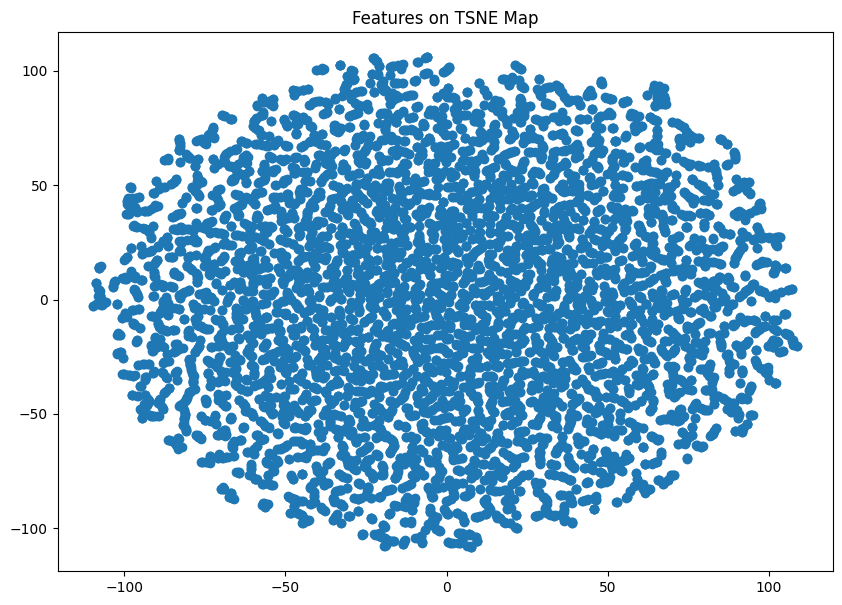

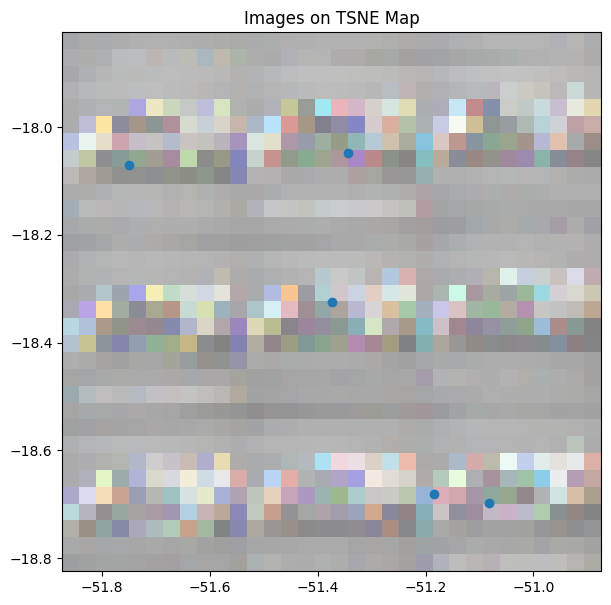

In [ ]:
# prompt: represent features on tsne map as well as images on tsne map for showing clusters and selected images

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensionality with TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
             init='random', perplexity=3)
X_embedded = tsne.fit_transform(features)

# Plot features on TSNE map
plt.figure(figsize=(10, 7))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
plt.title('Features on TSNE Map')
plt.show()

# Plot images on TSNE map
def plot_images_on_tsne(images, tsne_embedding, selected_indices):
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1])
    for i in selected_indices:
        image = images[i].reshape((32, 32, 3))
        ax.imshow(image, extent=(tsne_embedding[i, 0] - 0.5, tsne_embedding[i, 0] + 0.5,
                                 tsne_embedding[i, 1] - 0.5, tsne_embedding[i, 1] + 0.5),
                  alpha=0.5)
    plt.title('Images on TSNE Map')
    plt.show()

# Plot core set images on TSNE map
plot_images_on_tsne(X_train, X_embedded, selected_indices)


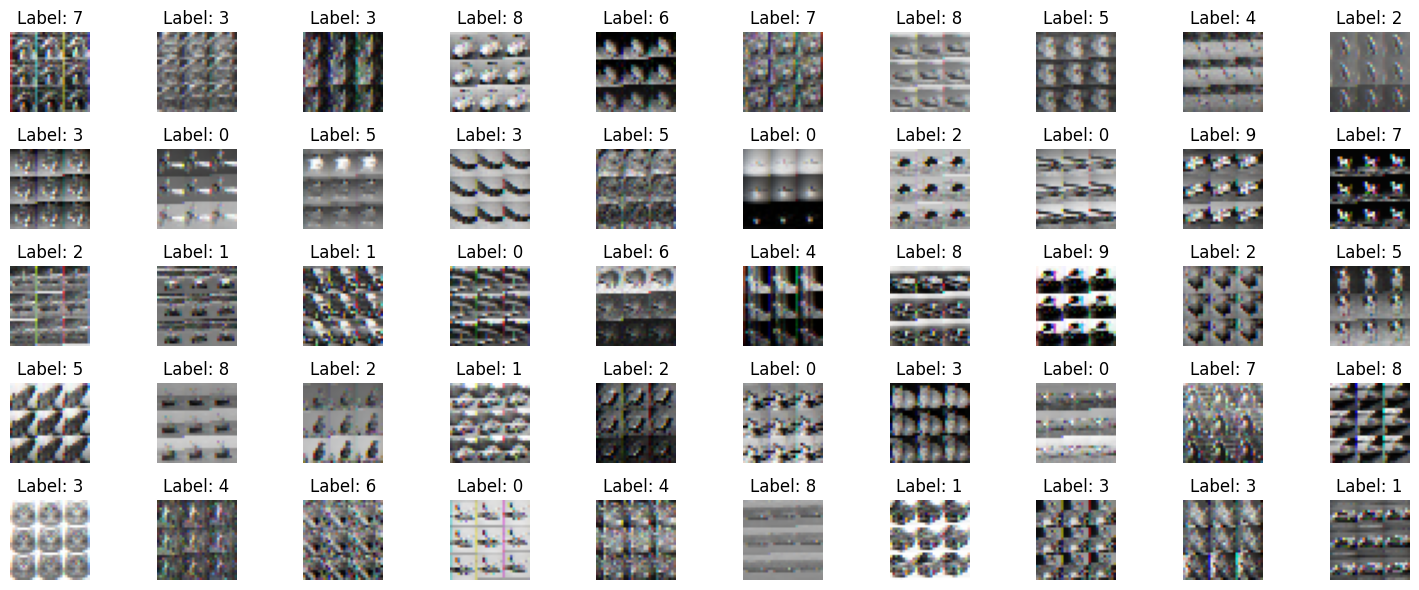

In [ ]:
import matplotlib.pyplot as plt

def visualize_selected_images(images, labels, selected_indices, image_size=(32, 32), grid_shape=(2, 5)):
    fig, axs = plt.subplots(nrows=grid_shape[0], ncols=grid_shape[1], figsize=(15, 6))
    axs = axs.flatten()  # Flatten the 2D array of axes for easy iteration

    for ax, idx in zip(axs, selected_indices):
        image = images[idx].reshape(image_size[0], image_size[1], 3)
        ax.imshow(image)
        ax.set_title(f"Label: {labels[idx]}")
        ax.axis('off')

    # Hide any remaining subplots if selected_indices < total grid cells
    for ax in axs[len(selected_indices):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# visualize_selected_images(X_train, y_train, selected_indices)
visualize_selected_images(X_train, y_train, selected_indices, grid_shape=(5, 10))
# visualize_selected_images(X_train, selected_indices)


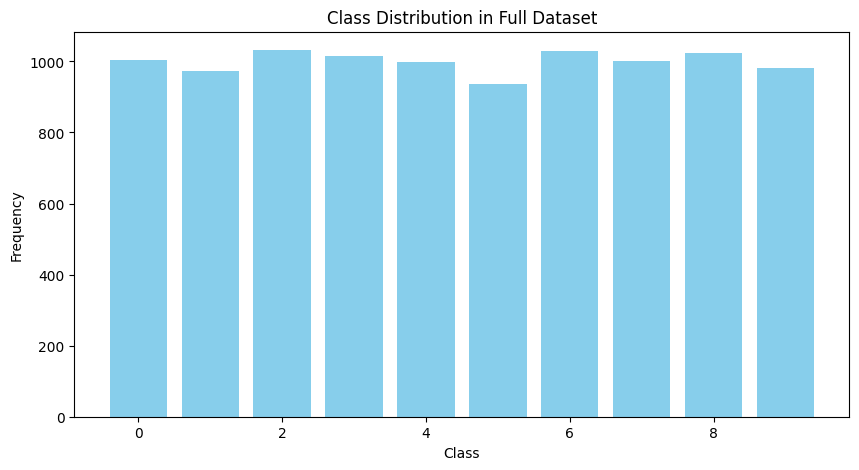

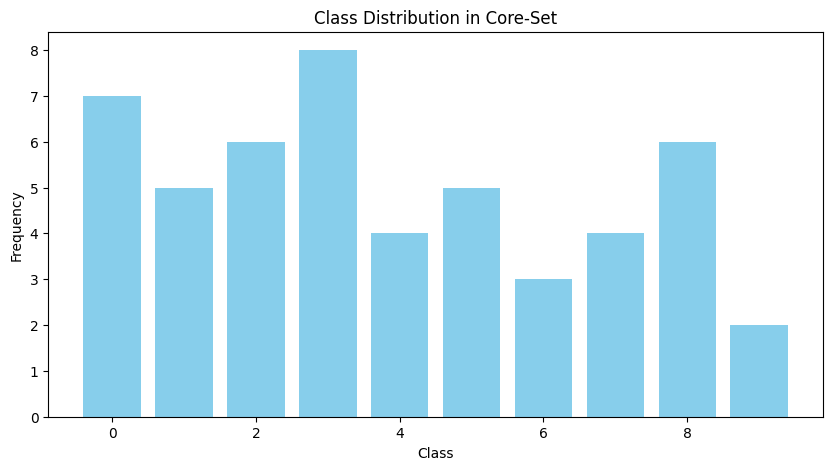

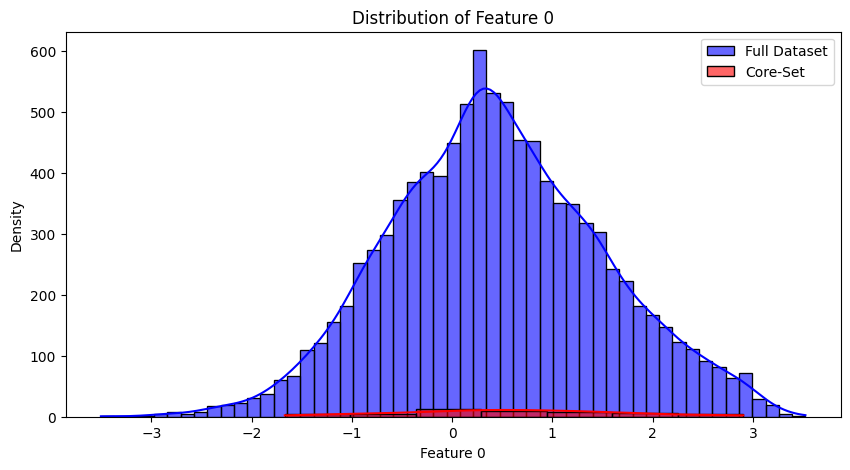

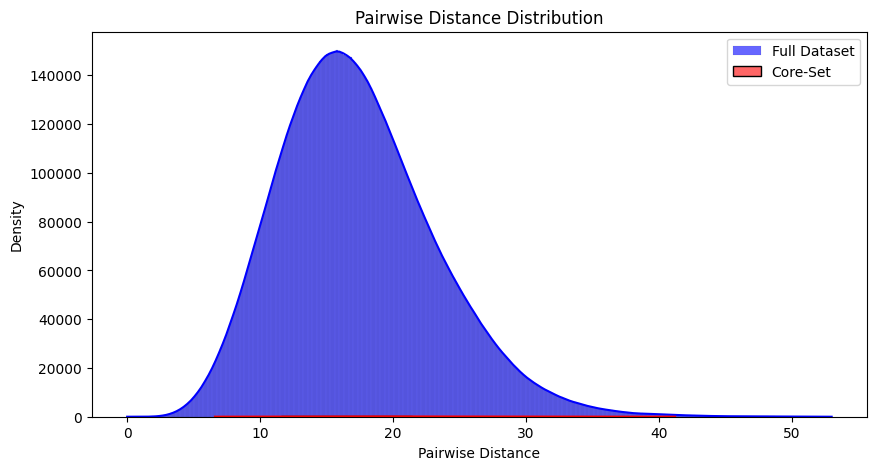

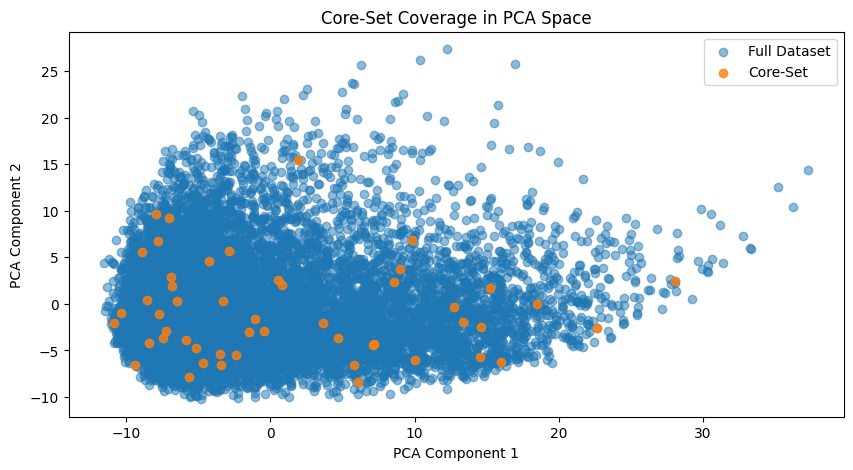

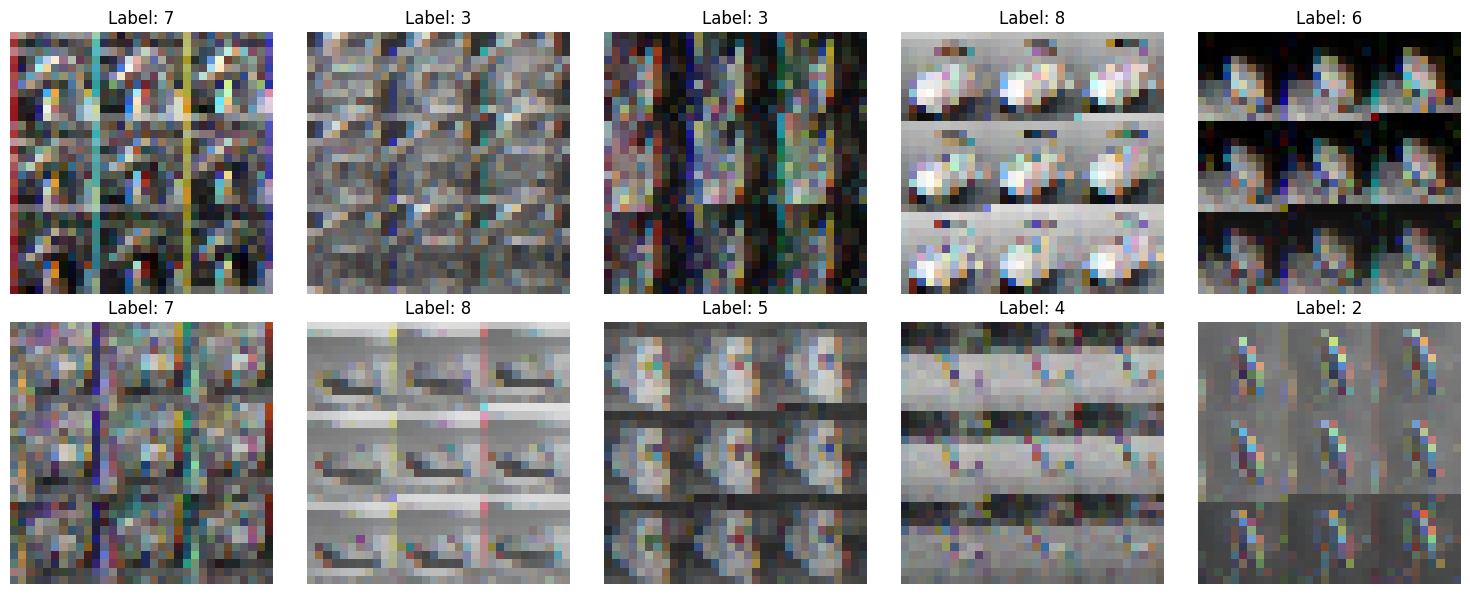

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

def investigate_core_set(images, labels, features, selected_indices, image_size=(32, 32), grid_shape=(2, 5)):
    # Class Distribution
    def plot_class_distribution(labels, title='Class Distribution'):
        class_counts = Counter(labels)
        sorted_counts = dict(sorted(class_counts.items()))
        plt.figure(figsize=(10, 5))
        plt.bar(sorted_counts.keys(), sorted_counts.values(), color='skyblue')
        plt.xlabel('Class')
        plt.ylabel('Frequency')
        plt.title(title)
        plt.show()

    # Feature Distribution Analysis
    def plot_feature_distribution(features, selected_indices, feature_idx=0):
        all_feature_values = features[:, feature_idx]
        core_set_feature_values = features[selected_indices, feature_idx]
        plt.figure(figsize=(10, 5))
        sns.histplot(all_feature_values, color='blue', kde=True, label='Full Dataset', alpha=0.6)
        sns.histplot(core_set_feature_values, color='red', kde=True, label='Core-Set', alpha=0.6)
        plt.xlabel(f'Feature {feature_idx}')
        plt.ylabel('Density')
        plt.title(f'Distribution of Feature {feature_idx}')
        plt.legend()
        plt.show()

    # Pairwise Distance Analysis
    def plot_pairwise_distances(features, selected_indices):
        all_distances = pairwise_distances(features)
        core_set_distances = pairwise_distances(features[selected_indices])
        all_distances = all_distances[np.triu_indices_from(all_distances, k=1)]
        core_set_distances = core_set_distances[np.triu_indices_from(core_set_distances, k=1)]
        plt.figure(figsize=(10, 5))
        sns.histplot(all_distances, color='blue', kde=True, label='Full Dataset', alpha=0.6)
        sns.histplot(core_set_distances, color='red', kde=True, label='Core-Set', alpha=0.6)
        plt.xlabel('Pairwise Distance')
        plt.ylabel('Density')
        plt.title('Pairwise Distance Distribution')
        plt.legend()
        plt.show()

    # Core-Set Coverage
    def plot_coverage(features, selected_indices):
        pca = PCA(n_components=2)
        reduced_features = pca.fit_transform(features)
        reduced_core_set = reduced_features[selected_indices]
        plt.figure(figsize=(10, 5))
        plt.scatter(reduced_features[:, 0], reduced_features[:, 1], alpha=0.5, label='Full Dataset')
        plt.scatter(reduced_core_set[:, 0], reduced_core_set[:, 1], alpha=0.8, label='Core-Set')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.title('Core-Set Coverage in PCA Space')
        plt.legend()
        plt.show()

    # Visualize Selected Images
    def visualize_selected_images(images, labels, selected_indices, image_size=(32, 32), grid_shape=(2, 5)):
        fig, axs = plt.subplots(nrows=grid_shape[0], ncols=grid_shape[1], figsize=(15, 6))
        axs = axs.flatten()
        for ax, idx in zip(axs, selected_indices):
            image = images[idx].reshape(image_size[0], image_size[1], 3)
            ax.imshow(image)
            ax.set_title(f"Label: {labels[idx]}")
            ax.axis('off')
        for ax in axs[len(selected_indices):]:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

    # Execute all analyses
    plot_class_distribution(labels, title='Class Distribution in Full Dataset')
    plot_class_distribution([labels[i] for i in selected_indices], title='Class Distribution in Core-Set')
    plot_feature_distribution(features, selected_indices, feature_idx=0)
    plot_pairwise_distances(features, selected_indices)
    plot_coverage(features, selected_indices)
    visualize_selected_images(images, labels, selected_indices, image_size=image_size, grid_shape=grid_shape)

# # Example usage with dummy data (replace with your actual data and selected indices)
# X_train = np.random.rand(1000, 32, 32, 3)  # Example image data
# y_train = np.random.randint(0, 10, size=(1000,))  # Example labels
# features = np.random.rand(1000, 64)  # Example features
# selected_indices = np.random.choice(len(y_train), size=10, replace=False)  # Example selected indices

investigate_core_set(X_train, y_train, features, selected_indices)


[6307,
 3834,
 2324,
 9730,
 9170,
 8076,
 4159,
 7293,
 520,
 830,
 5578,
 1319,
 2147,
 5966,
 4004,
 4651,
 4431,
 3570,
 3928,
 4933,
 8843,
 3273,
 8244,
 9566,
 5085,
 2304,
 7561,
 7441,
 3446,
 5467,
 7103,
 4320,
 3301,
 9095,
 2737,
 4490,
 7132,
 9718,
 3955,
 6501,
 8029,
 1269,
 9953,
 3076,
 1889,
 8397,
 2185,
 2270,
 9300,
 5261]